In [21]:
import numpy as np 
import pandas as pd 
import os

from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, date 

import warnings # Supress warnings 
warnings.filterwarnings('ignore')


ori = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
df = ori.copy()
print(ori.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None


In [22]:
obj = ori.select_dtypes(include='object')
for c in obj:
    print(c,len(ori[c].unique()), '-', ori[c].unique())

date 2557 - ['2010-01-01' '2010-01-02' '2010-01-03' ... '2016-12-29' '2016-12-30'
 '2016-12-31']
country 6 - ['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
store 3 - ['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
product 5 - ['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


# Decomposing

In [23]:
# Decompose time data

def timedecompose(df):

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = pd.DatetimeIndex(df['date']).quarter
    df['season'] = df['month']%12 // 3 + 1

    return df

df = timedecompose(df)
test = timedecompose(test)

# Get CPI and GDP

In [24]:
# Get CPI data

cpi = pd.read_excel('/kaggle/input/global-economic-monitor/CPI Price  y-o-y nominal seas. adj..xlsx',sheet_name='monthly', header=0)
cpi = cpi.rename(columns={"Unnamed: 0": "year"})
parsed_date = pd.to_datetime(cpi['year'], format="%YM%m")

cpi['year'] = parsed_date.dt.year
cpi['month'] = parsed_date.dt.month

cpi = cpi.drop(cpi[cpi['year']<2010].index, axis=0)
cpi = cpi.drop([0], axis=0)

cpi['year'] = cpi['year'].astype(int)
cpi['month'] = cpi['month'].astype(int)

df_cpi = pd.melt(cpi, id_vars=["year", "month"], 
                    var_name="country", 
                    value_name="cpi")

df = pd.merge(how='left', left=df, right=df_cpi,
             left_on=['year','month','country'],
             right_on=['year','month','country'])

test = pd.merge(how='left', left=test, right=df_cpi,
             left_on=['year','month','country'],
             right_on=['year','month','country'])

In [25]:
# Get CPI quarterly data

df['cpi_quarter'] = df['cpi'].rolling(90, min_periods=30, center=True).mean()
test['cpi_quarter'] = test['cpi'].rolling(90, min_periods=30, center=True).mean()


In [26]:
# Get GDP data

gdp = pd.read_excel('/kaggle/input/global-economic-monitor/GDP at market prices current LCU millions seas. adj..xlsx',sheet_name='quarterly', header=0)
gdp = gdp.rename(columns={"Unnamed: 0": "time"}).dropna()
gdp['time'] = gdp['time'].str.rstrip()

gdp['year'] = gdp['time'].str[:4].astype(int)
gdp['quarter'] = gdp['time'].str[-1:].astype(int)

gdp = gdp.drop(gdp[gdp['year']<2010].index, axis=0)

df_gdp = pd.melt(gdp, id_vars=["year", "quarter"], 
                    var_name="country", 
                    value_name="gdp")

df = pd.merge(how='left', left=df, right=df_gdp,
             left_on=['year','quarter','country'],
             right_on=['year','quarter','country'])

test = pd.merge(how='left', left=test, right=df_gdp,
             left_on=['year','quarter','country'],
             right_on=['year','quarter','country'])

df['gdp'] = df['gdp'].astype(int)
test['gdp'] = test['gdp'].astype(int)



# Missing values

In [27]:
# nosale by product
nosale = df[df['num_sold'].isnull()==True]
nosale.groupby(['product','store','country','year',]).agg({'id':'count'})

id
product            store                country year     
Holographic Goose  Discount Stickers    Canada  2010  365
                                                2011  365
                                                2012  366
                                                2013  365
                                                2014  365
                                                2015  365
                                                2016  366
                                        Kenya   2010  365
                                                2011  365
                                                2012  366
                                                2013  365
                                                2014  365
                                                2015  365
                                                2016  366
                   Premium Sticker Mart Canada  2010   77
                                                2011    3
                                                2012   12
                                                2013   20
                                                2014   23
                                                2015  115
                                                2016  130
                                        Kenya   2010  277
                                                2011  217
                                                2012   92
                                                2013   48
                                                2014   10
                                                2015    2
                   Stickers for Less    Canada  2010  235
                                                2011  107
                                                2012  120
                                                2013  131
                                                2014  151
                                                2015  282
                                                2016  282
                                        Kenya   2010  343
                                                2011  331
                                                2012  265
                                                2013  200
                                                2014  113
                                                2015   78
                                                2016   28
Kerneler           Discount Stickers    Canada  2016    1
                                        Kenya   2010   46
                                                2011   17
Kerneler Dark Mode Discount Stickers    Kenya   2010    1

In [28]:
# Dropping rows that are Holographic Goose, at store Discount Stickers, in Kenya and Canada
df = df.drop(df[
             (df['product']=='Holographic Goose') & 
             (df['store']=='Discount Stickers') & 
             ((df['country']=='Canada') | (df['country']=='Kenya'))
             ].index, 
             axis=0)

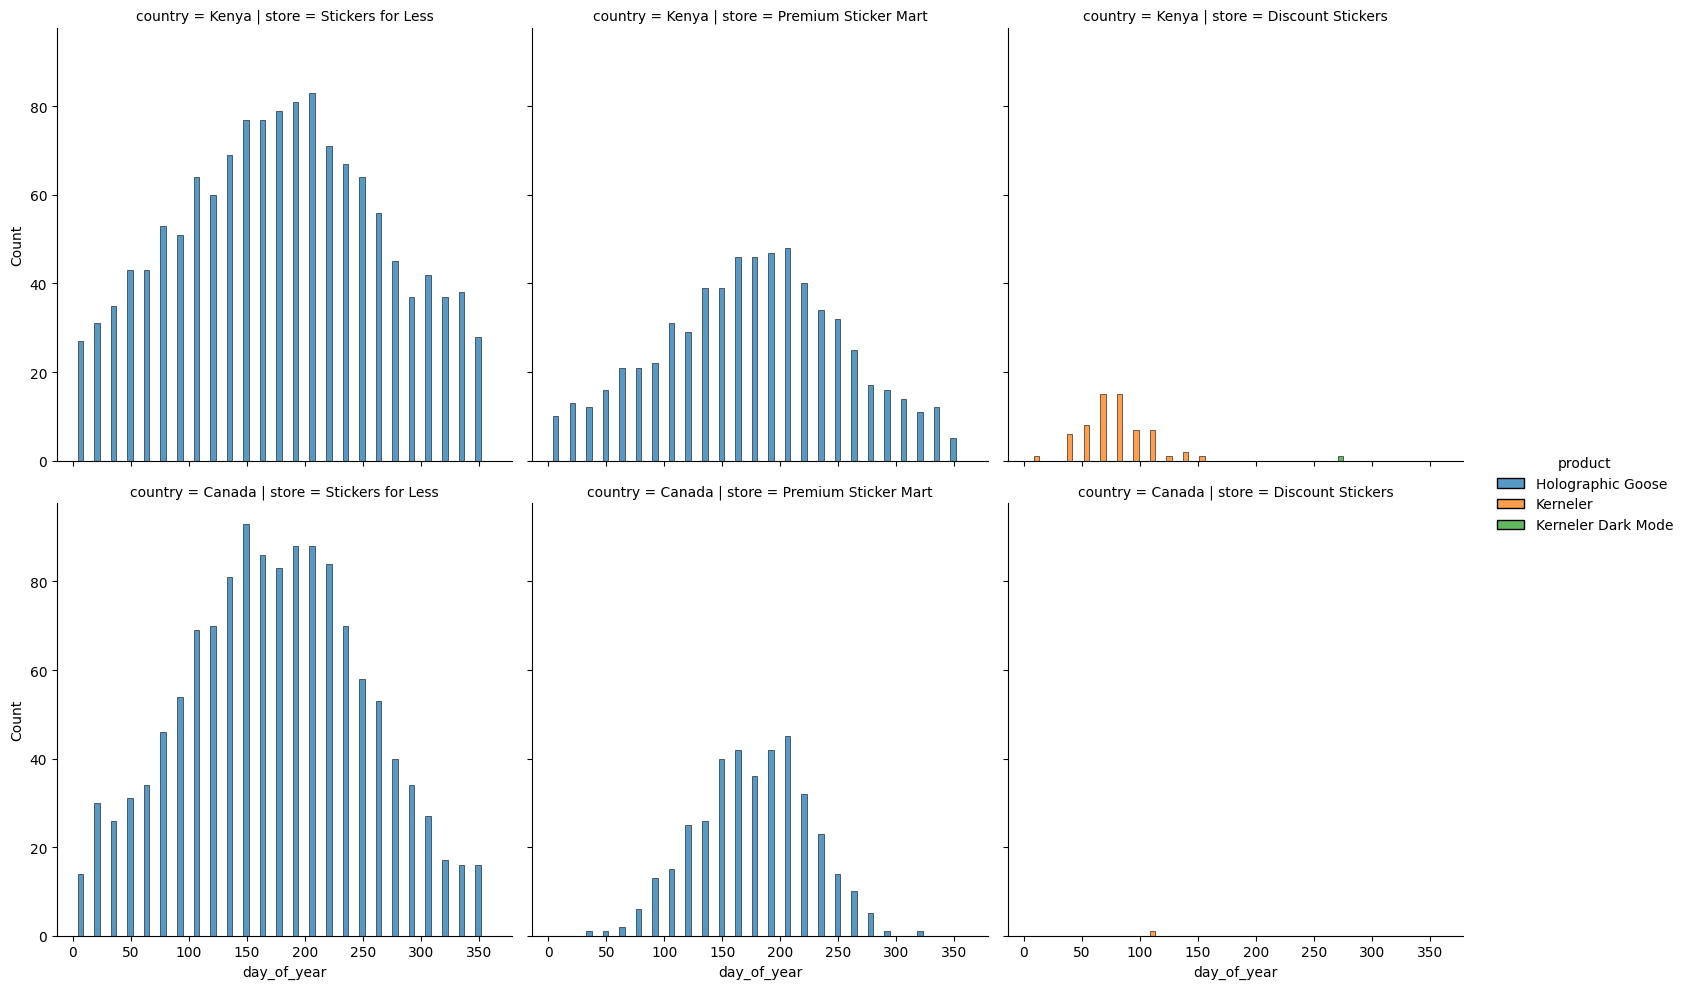

In [29]:
# Missing values distribution by day of year
nosale2 = df[df.num_sold.isnull()==True]
sns.displot(data=nosale2, x='day_of_year', hue='product', row='country', col='store', multiple='dodge')
plt.show()

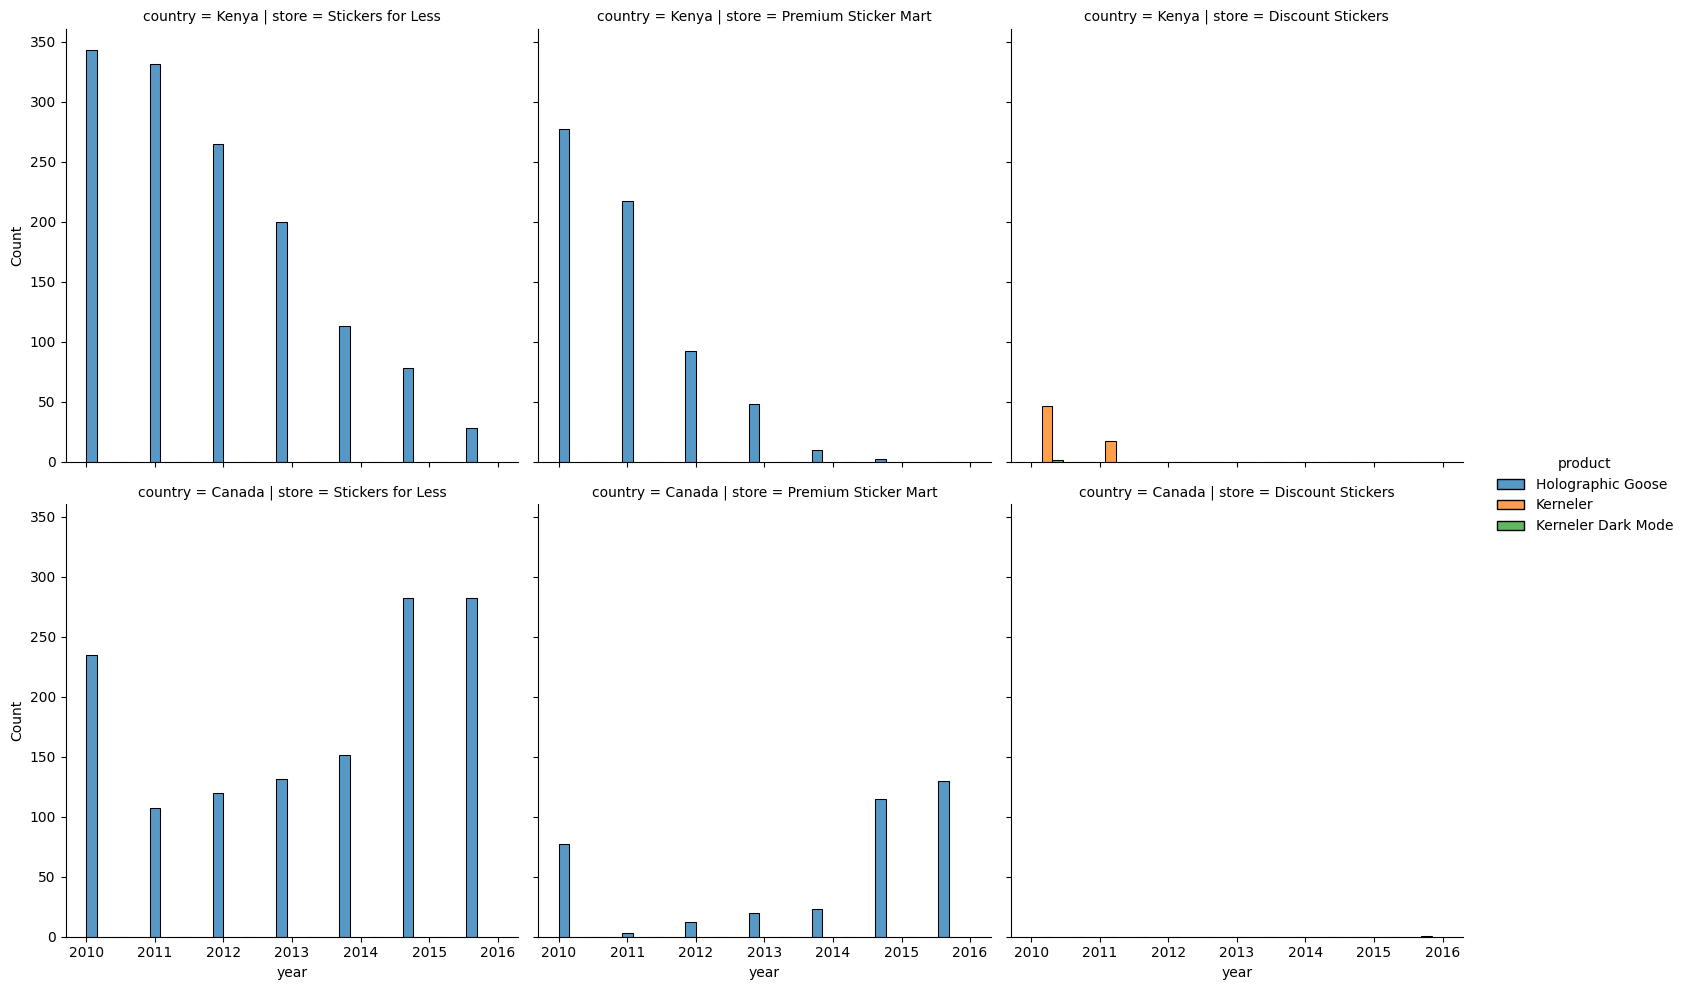

In [30]:
# Missing values over time
nosale2 = df[df.num_sold.isnull()==True]
sns.displot(data=nosale2, x='year', hue='product', row='country', col='store', multiple='dodge')
plt.show()

- Kenya's number of missing values increased over the years.  
- Canada's number of missing values decreased over the years.

# Transforming (differencing)

In [31]:
# # Tranforming features

# def rolling_sale(df):
#     df['total_last_1w'] = df['num_sold'].rolling(7, min_periods=1).sum()
#     df['total_last_2w'] = df['num_sold'].rolling(14, min_periods=1).sum()
#     df['total_last_4w'] = df['num_sold'].rolling(28, min_periods=1).sum()
#     df['total_last_8w'] = df['num_sold'].rolling(56, min_periods=1).sum()
#     df['total_last_q'] = df['num_sold'].rolling(120, min_periods=1).sum()
#     df['total_last_6m'] = df['num_sold'].rolling(180, min_periods=1).sum()
#     df['total_last_y'] = df['num_sold'].rolling(365, min_periods=1).sum()
    
#     df['total_1w_center'] = df['num_sold'].rolling(7, min_periods=1, center=True).sum()
#     df['total_2w_center'] = df['num_sold'].rolling(14, min_periods=1, center=True).sum()
#     df['total_4w_center'] = df['num_sold'].rolling(28, min_periods=1, center=True).sum()
#     df['total_8w_center'] = df['num_sold'].rolling(56, min_periods=1, center=True).sum()
#     df['total_q_center'] = df['num_sold'].rolling(120, min_periods=1, center=True).sum()
#     df['total_6m_center'] = df['num_sold'].rolling(180, min_periods=1, center=True).sum()
#     df['total_y_center'] = df['num_sold'].rolling(365, min_periods=1, center=True).sum()
    
#     df['avg_last_1w'] = df['num_sold'].rolling(7, min_periods=1).mean()
#     df['avg_last_2w'] = df['num_sold'].rolling(14, min_periods=1).mean()
#     df['avg_last_4w'] = df['num_sold'].rolling(28, min_periods=1).mean()
#     df['avg_last_8w'] = df['num_sold'].rolling(56, min_periods=1).mean()
#     df['avg_last_q'] = df['num_sold'].rolling(120, min_periods=1).mean()
#     df['avg_last_6m'] = df['num_sold'].rolling(180, min_periods=1).mean()
#     df['avg_last_y'] = df['num_sold'].rolling(366, min_periods=1).mean()
    
#     df['avg_1w_center'] = df['num_sold'].rolling(7, min_periods=1, center=True).mean()
#     df['avg_2w_center'] = df['num_sold'].rolling(14, min_periods=1, center=True).mean()
#     df['avg_4w_center'] = df['num_sold'].rolling(28, min_periods=1, center=True).mean()
#     df['avg_8w_center'] = df['num_sold'].rolling(56, min_periods=1, center=True).mean()
#     df['avg_q_center'] = df['num_sold'].rolling(120, min_periods=1, center=True).mean()
#     df['avg_6m_center'] = df['num_sold'].rolling(180, min_periods=1, center=True).mean()
#     df['avg_y_center'] = df['num_sold'].rolling(365, min_periods=1, center=True).mean()

#     df['1D_diff'] = df['num_sold'] - df['num_sold'].shift(1)
#     df['1W_diff'] = df['num_sold'] - df['num_sold'].shift(7)
#     df['1M_diff'] = df['num_sold'] - df['num_sold'].shift(28)
#     df['3M_diff'] = df['num_sold'] - df['num_sold'].shift(90)
#     df['1Y_diff'] = df['num_sold'] - 0.5 * (df['num_sold'].shift(365) + df['num_sold'].shift(366))
#     df['2Y_diff'] = df['num_sold'] - 0.5 * (df['num_sold'].shift(730) + df['num_sold'].shift(731))
        
#     return df

# df = rolling_sale(df)

# Grouping by Product, Store, Country

In [32]:
# Grouping by product, store, country

def separating(df):
    list_country = df['country'].unique().tolist()
    list_product = df['product'].unique().tolist()
    list_store = df['store'].unique().tolist()
    
    dfs = {}
    for product in list_product:
        for store in list_store:
            for country in list_country:
                i = product + '_' + store + '_' + country
                dfi = df[(df['product']==product) & (df['store']==store) & (df['country']==country)]
                dfs[i] = dfi

    return dfs

In [33]:
dfs = separating(df)

## Trends with CPI and GDP

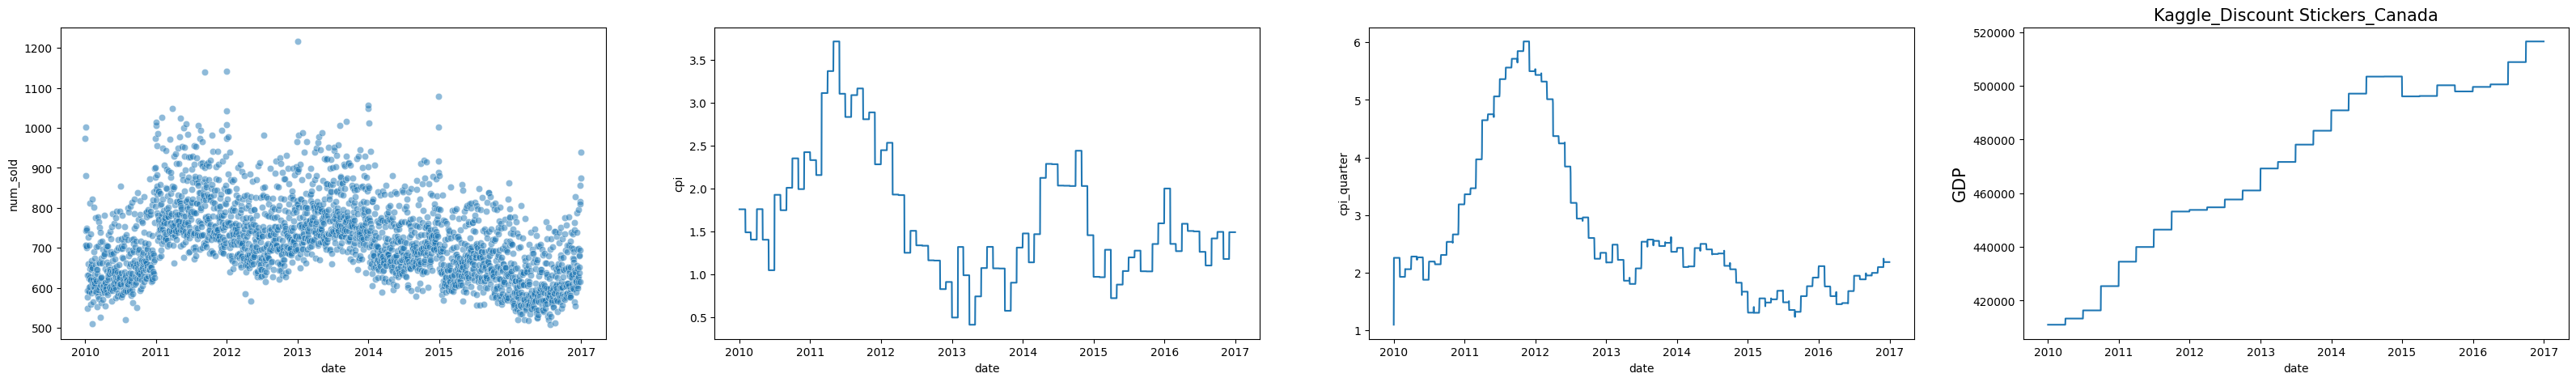

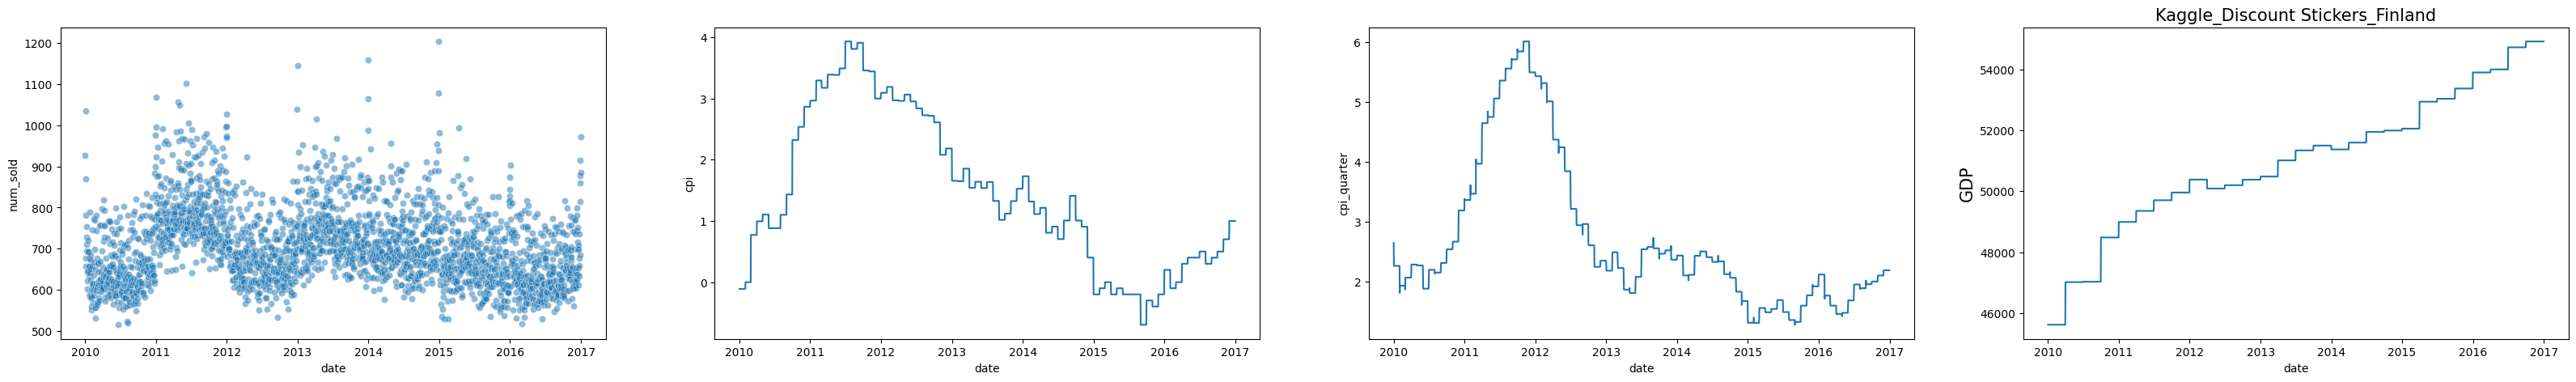

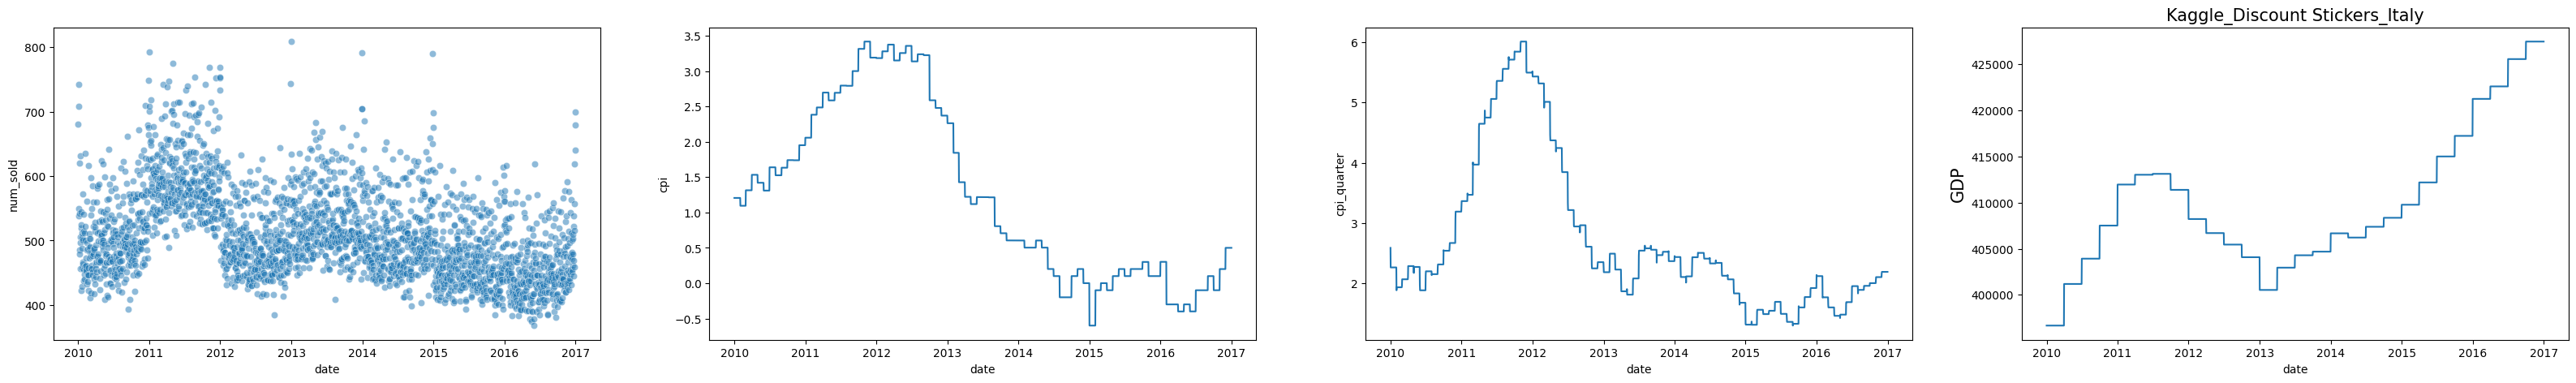

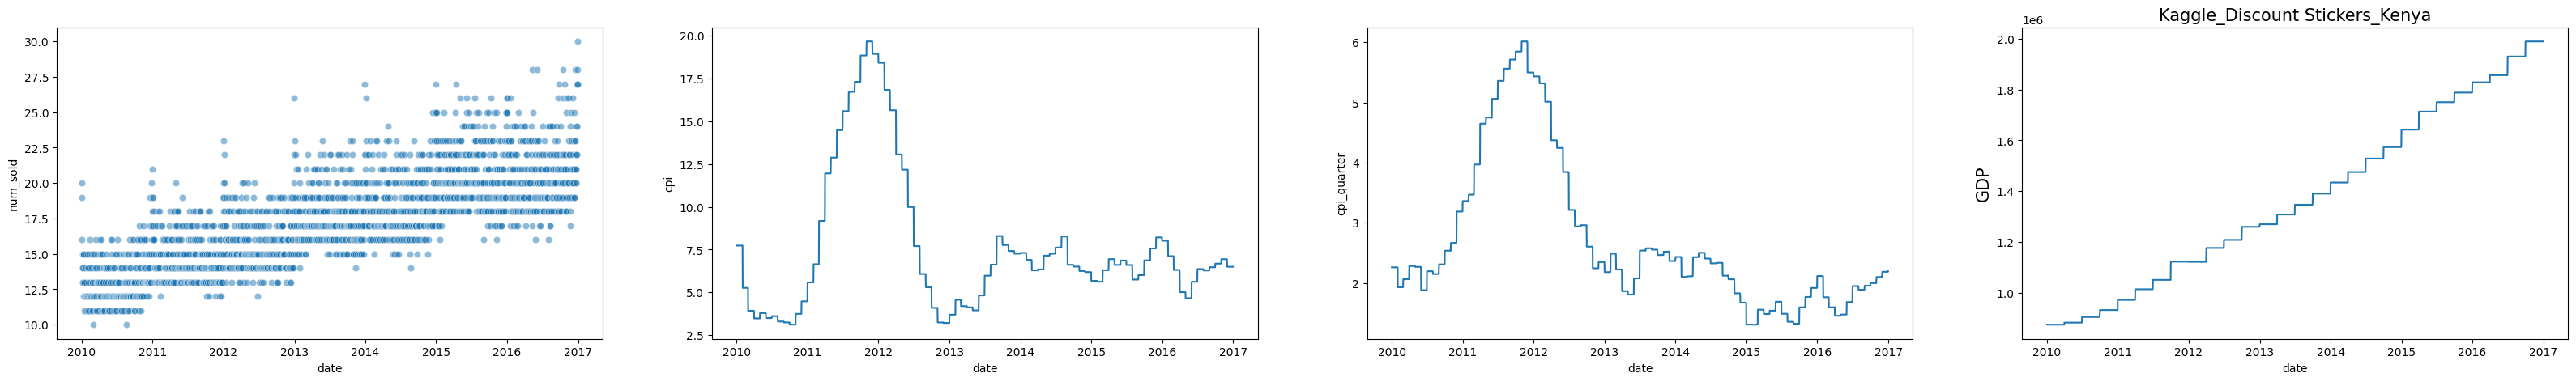

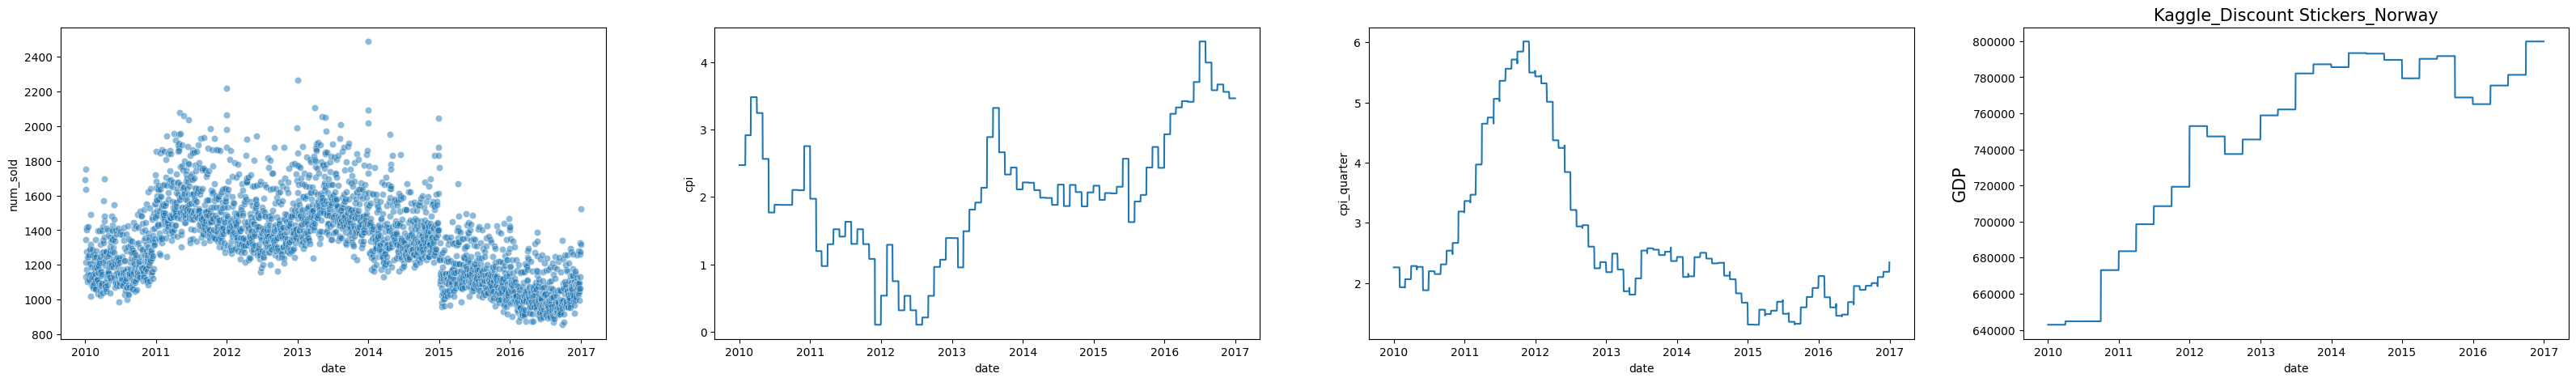

In [34]:
list_key = list(dfs.keys())
for k in list_key[0:5]:
    d = dfs[k]
    f, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(1, 4, figsize=(40,5), gridspec_kw={"width_ratios": (.25, .25, .25, .25)})
    
    sns.scatterplot(x=d.date, y=d['num_sold'].fillna(np.inf), alpha=0.5, ax=ax_1)
    plt.ylabel('Num_sold', fontsize=15)
    plt.title(k, fontsize=15)
    
    sns.lineplot(x=d.date, y=d['cpi'], ax=ax_2)
    plt.ylabel('CPI', fontsize=15)

    sns.lineplot(x=d.date, y=d['cpi_quarter'], ax=ax_3)
    plt.ylabel('CPI Quarter', fontsize=15)
    
    sns.lineplot(x=d.date, y=d['gdp'], ax=ax_4)
    plt.ylabel('GDP', fontsize=15)
    
    plt.show()

## Correlation for each PSC


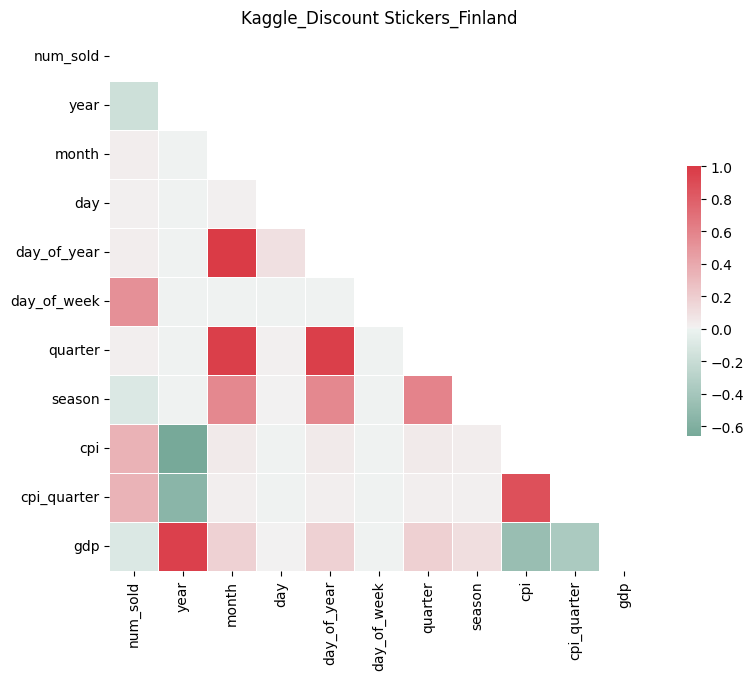

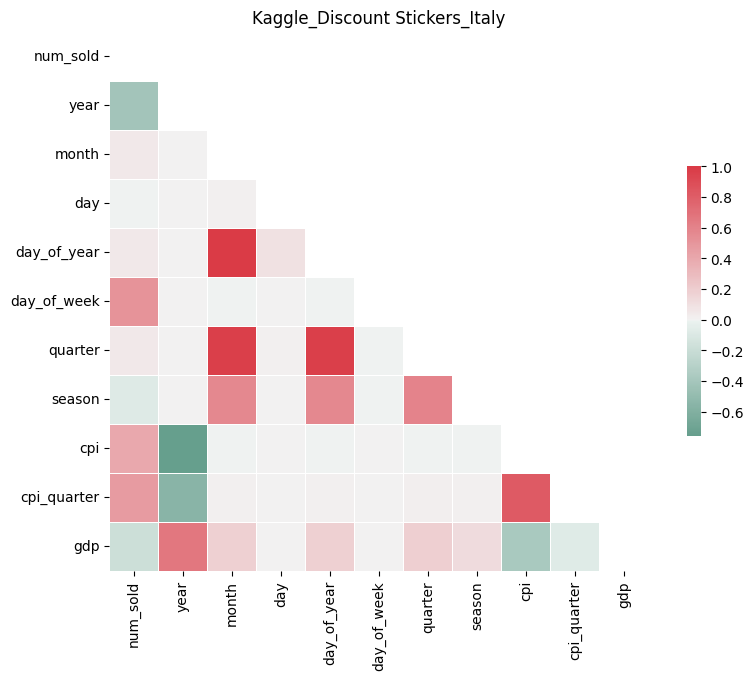

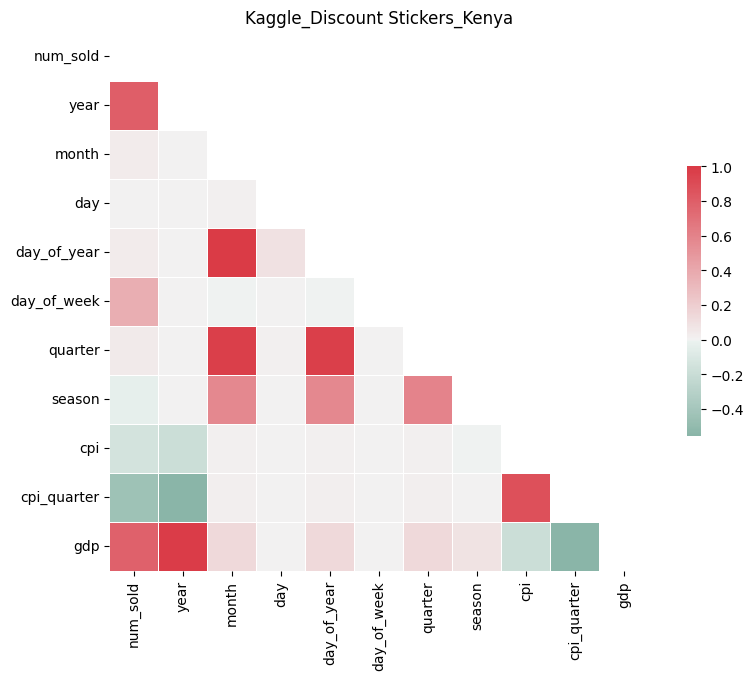

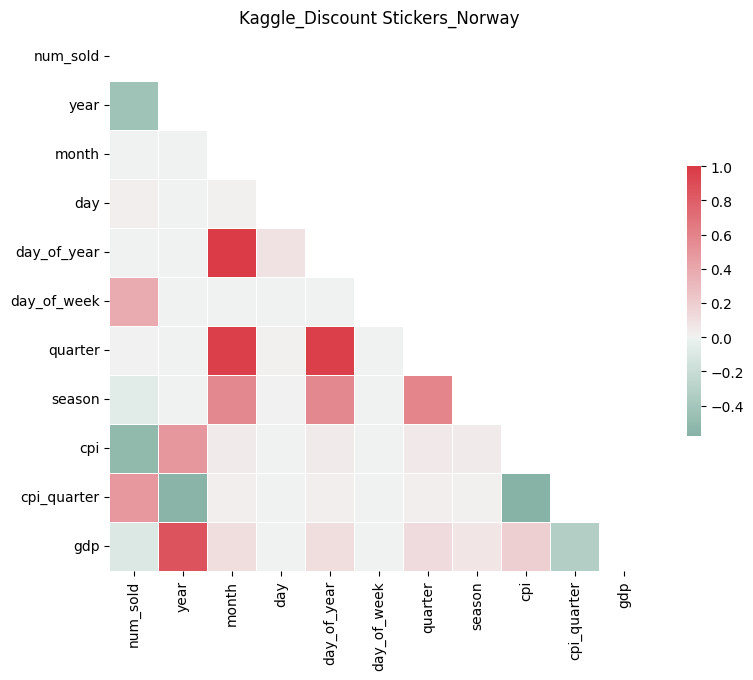

In [35]:
list_key = list(dfs.keys())
for k in list_key[1:5]:
    num_var = dfs[k].select_dtypes(include=['float','int']).drop('id', axis=1)
    corr = num_var.corr(method='pearson',)
    
    # Visualization of correlations using a heatmap
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(10, 7))
    cmap = sns.diverging_palette(-200, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(k)
    plt.show()

# Interpolation

- Method: linear
- Limit Direction: backward for Kenya, foward for Canada
- Limit: weekly (7), looping until all filled.

In [36]:
null_df = []
for k in dfs.keys():
    if (dfs[k]['num_sold'].isnull().sum()>0): 
        x = dfs[k]['num_sold'].isnull().sum()
        print(f'{k}: {x}')
        null_df.append(k)

for k in null_df:
    j = dfs[k]['num_sold'].isnull().sum()
    while j>0:
        if 'Kenya' in k.split('_'):
            dfs[k]['num_sold'].interpolate(method='linear', limit=7, limit_direction='backward', inplace=True)
        else:
            dfs[k]['num_sold'].interpolate(method='linear', limit=7, limit_direction='forward', inplace=True)
        j = dfs[k]['num_sold'].isnull().sum()
        if j == 0:
            break
    

Kerneler_Discount Stickers_Canada: 1
Kerneler_Discount Stickers_Kenya: 63
Kerneler Dark Mode_Discount Stickers_Kenya: 1
Holographic Goose_Stickers for Less_Canada: 1308
Holographic Goose_Stickers for Less_Kenya: 1358
Holographic Goose_Premium Sticker Mart_Canada: 380
Holographic Goose_Premium Sticker Mart_Kenya: 646


# Regrouping

In [40]:
len(dfs.keys())

90

In [37]:
# Regrouping
train_new = pd.concat(dfs.values(), 
                  axis = 0)

In [38]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225016 entries, 1 to 230125
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            225016 non-null  int64         
 1   date          225016 non-null  datetime64[ns]
 2   country       225016 non-null  object        
 3   store         225016 non-null  object        
 4   product       225016 non-null  object        
 5   num_sold      225016 non-null  float64       
 6   year          225016 non-null  int32         
 7   month         225016 non-null  int32         
 8   day           225016 non-null  int32         
 9   day_of_year   225016 non-null  int32         
 10  week_of_year  225016 non-null  UInt32        
 11  day_of_week   225016 non-null  int32         
 12  quarter       225016 non-null  int32         
 13  season        225016 non-null  int32         
 14  cpi           225016 non-null  float64       
 15  cpi_quarter   225016 n

In [39]:
if train_new['num_sold'].isnull().sum() ==0:
    df.to_csv('train_new.csv', index=False)
    test.to_csv('test_new.csv', index=False)
else:
    print('Missing values found in target variable.')

(to be continued)

---

|Date|Task|Status|
|-|-|-|
|Jan 11|Functions for rolling sales, time decomposition |Done|
|Jan 11|Multivariate to Univariate time series |Done|
|Jan 11|Get CPI monthly data |Done|
|Jan 12|Get GDP data |Done|
|Jan 12|Calculate quarterly CPI data |Done|
|Jan 12|Fill NA with interpolation, concatenating preprocessed PSCs |Done|